In [180]:
import os
import pandas as pd
import numpy as np
import yfinance
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [181]:
data=pd.read_csv("Google_Stock_Train (2010-2022).csv") #load and check data 
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


In [182]:
data["Date"] = pd.to_datetime(data["Date"]) #convert date to datetime64 format

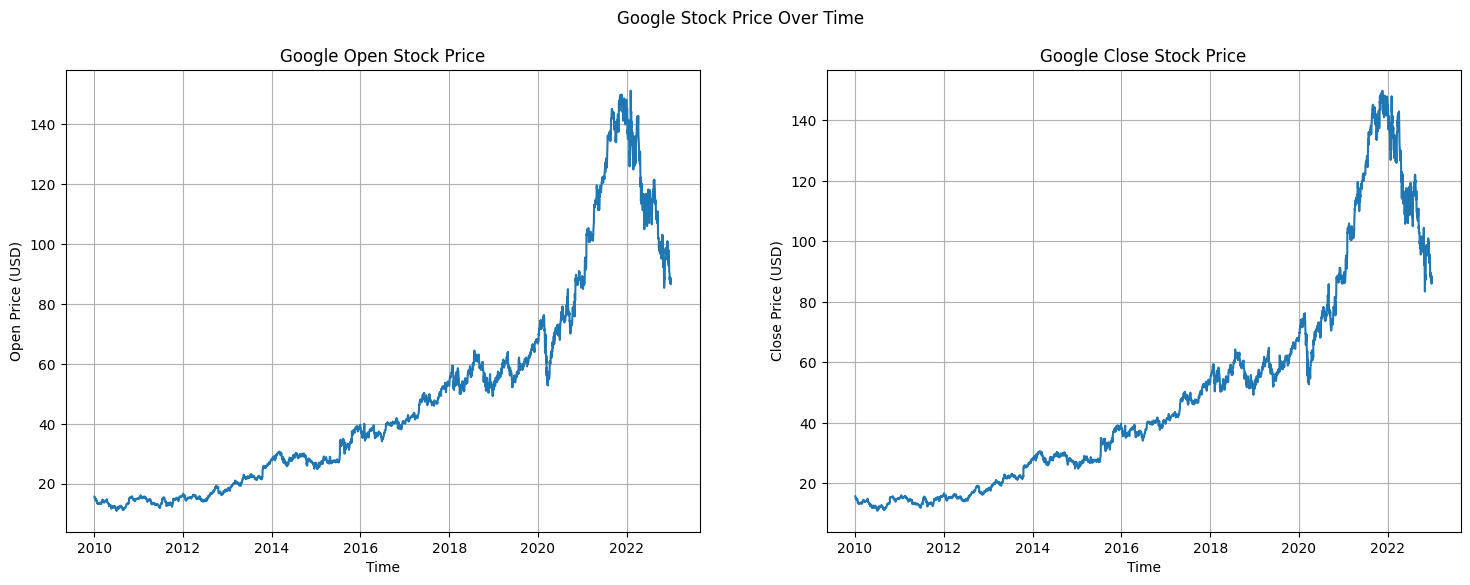

In [183]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Google Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Google Close Stock Price")
plt.grid()

plt.suptitle("Google Stock Price Over Time")
plt.show()

In [184]:
def calculate_rsi(data, period=14):
    delta = data.diff()
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [185]:
#Creating Technical Indicators
data["SMA14"]=data["Close"].rolling(window=14).mean()
data["WMA14"] = data["Close"].rolling(window=14).apply(lambda x: np.sum(range(1,15)*x) / 105, raw=False)
data["Momentum"]=data["Close"].diff(periods=14)
data["ADO"]=(data["High"]-data["Close"])/(data["High"]-data["Low"])
data["M"]=(data["High"]+data["Low"]+data["Close"])/3
data["SM"]=data["M"].rolling(window=10).mean()
data["LL14"]=data["Low"].rolling(window=14).min()
data["HH14"]=data["High"].rolling(window=14).max()
data["STCK"]=((data["Close"]-data["LL14"])/(data["HH14"]-data["LL14"]))*100
data["STCD"]=data["STCK"].rolling(window=14).mean()
data["STCD"]=100*data["STCD"]
data["LWR"]=((data["HH14"]-data["Close"])/(data["HH14"]-data["LL14"]))*100
data["RSI"]=calculate_rsi(data['Close'], period=14)
data["D"] = data["M"].rolling(window=14).apply(lambda x: abs(x - x.mean()).mean(), raw=False)
data["CCI"]=(data["M"]-data["SM"])/(0.015*data["D"])
data["EMA_Fast"] = data["Close"].ewm(span=12, adjust=False).mean()
data["EMA_Slow"] = data["Close"].ewm(span=16, adjust=False).mean()
data["MACD"] = data["EMA_Fast"] - data["EMA_Slow"]
data["Signal"] = data["MACD"].ewm(span=14, adjust=False).mean()

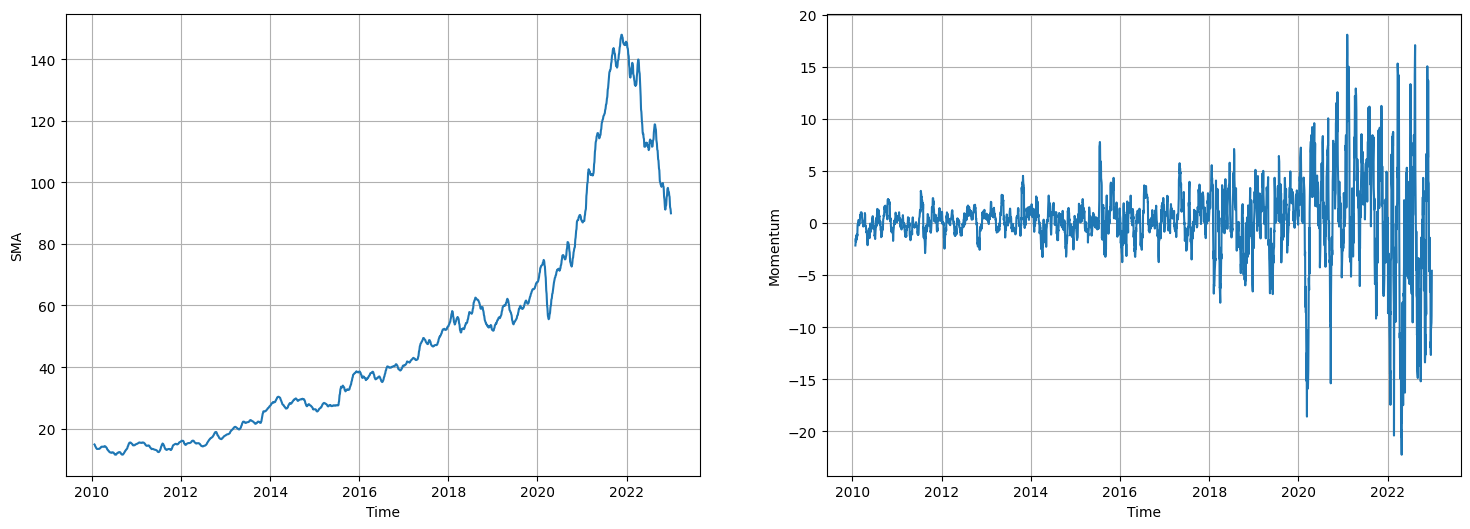

In [186]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["SMA14"])
plt.xlabel("Time")
plt.ylabel("SMA")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Momentum"])
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.grid()

plt.show()

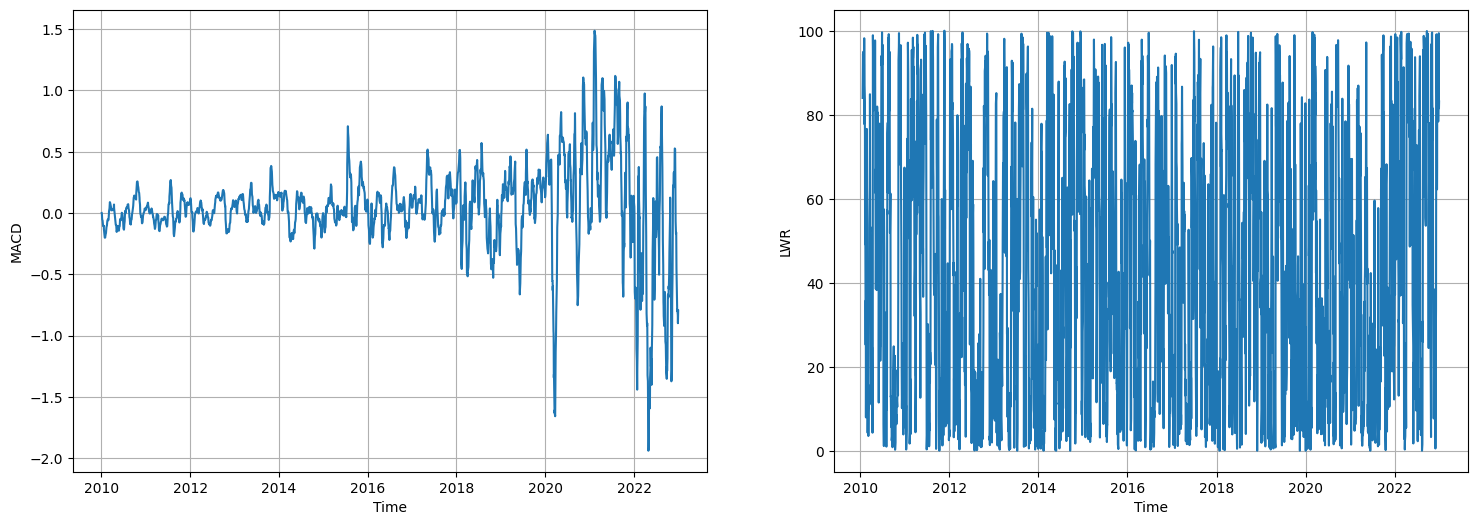

In [187]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["MACD"])
plt.xlabel("Time")
plt.ylabel("MACD")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["LWR"])
plt.xlabel("Time")
plt.ylabel("LWR")
plt.grid()

plt.show()

In [188]:
# Define target attribute
data["target"]=data["Adj Close"]-data["Open"]
data["target"]=data["target"].shift(-1)
data["targetClass"]=data["target"].apply(lambda x: 1 if x > 0 else 0)

In [189]:
data.dropna(inplace=True)

In [190]:
columns=data.drop(["Date"], axis=1).columns
minmax=preprocessing.MinMaxScaler()
scaled=minmax.fit_transform(data.drop(["Date"], axis=1))
pd.DataFrame(scaled,columns=columns).var().sort_values(ascending=False)

targetClass    0.250045
STCK           0.093715
LWR            0.093715
ADO            0.090672
HH14           0.072374
EMA_Slow       0.069511
EMA_Fast       0.068840
SMA14          0.068711
SM             0.068395
WMA14          0.068332
M              0.066710
High           0.066485
Adj Close      0.066436
Close          0.066436
Low            0.065728
Open           0.065185
LL14           0.064127
STCD           0.059946
RSI            0.031908
D              0.028457
CCI            0.017010
Signal         0.012995
MACD           0.010870
Momentum       0.008176
Volume         0.006927
target         0.003807
dtype: float64

In [191]:
cor=data.drop(["Date"], axis=1).corr(method="spearman")
cor["target"].sort_values(ascending=False)

target         1.000000
targetClass    0.865969
ADO            0.031377
LWR            0.024361
LL14           0.023501
SMA14          0.023124
HH14           0.023029
SM             0.022836
EMA_Slow       0.022516
WMA14          0.022378
EMA_Fast       0.022214
Open           0.021892
Low            0.021438
High           0.021389
M              0.021160
Adj Close      0.020814
Close          0.020814
D              0.015458
Signal        -0.012917
CCI           -0.020774
STCD          -0.021110
STCK          -0.024361
RSI           -0.028673
Volume        -0.028894
MACD          -0.030209
Momentum      -0.031976
Name: target, dtype: float64

<Axes: >

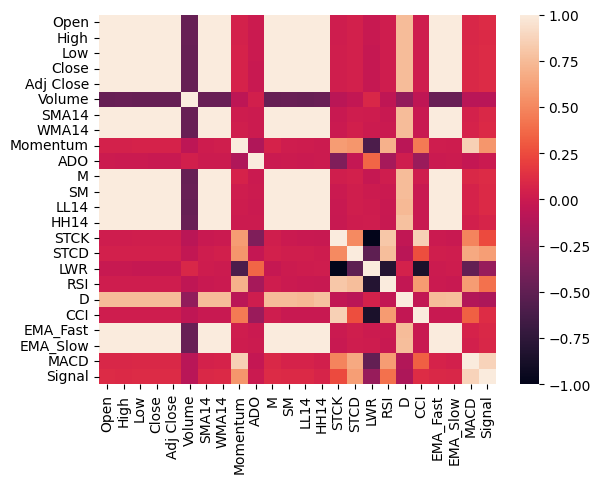

In [192]:
sns.heatmap(data.drop(["target","targetClass","Date"], axis=1).corr())

<Axes: >

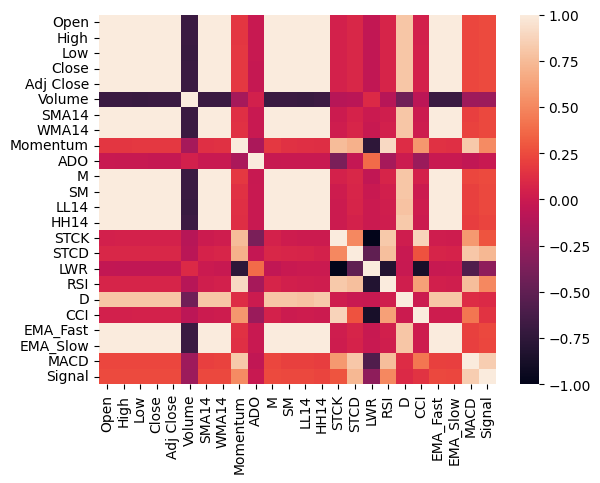

In [193]:
sns.heatmap(data.drop(["target","targetClass","Date"], axis=1).corr(method="spearman"))

In [194]:
table=data.drop(["target","targetClass","Date"], axis=1).corr(method="spearman")
columns=data.drop(["target","targetClass","Date"], axis=1).columns
cache=[]
for j in columns:
    for i in columns:
        if(abs(table[i][j])>=0.7 and not(i in j)):
            if(not (([i,j] or [j,i]) in cache)):
                cache.append([i,j])
print(cache)

[['High', 'Open'], ['Low', 'Open'], ['Close', 'Open'], ['Adj Close', 'Open'], ['SMA14', 'Open'], ['WMA14', 'Open'], ['M', 'Open'], ['SM', 'Open'], ['LL14', 'Open'], ['HH14', 'Open'], ['D', 'Open'], ['EMA_Fast', 'Open'], ['EMA_Slow', 'Open'], ['Open', 'High'], ['Low', 'High'], ['Close', 'High'], ['Adj Close', 'High'], ['SMA14', 'High'], ['WMA14', 'High'], ['M', 'High'], ['SM', 'High'], ['LL14', 'High'], ['HH14', 'High'], ['D', 'High'], ['EMA_Fast', 'High'], ['EMA_Slow', 'High'], ['Open', 'Low'], ['High', 'Low'], ['Close', 'Low'], ['Adj Close', 'Low'], ['SMA14', 'Low'], ['WMA14', 'Low'], ['M', 'Low'], ['SM', 'Low'], ['LL14', 'Low'], ['HH14', 'Low'], ['D', 'Low'], ['EMA_Fast', 'Low'], ['EMA_Slow', 'Low'], ['Open', 'Close'], ['High', 'Close'], ['Low', 'Close'], ['Adj Close', 'Close'], ['SMA14', 'Close'], ['WMA14', 'Close'], ['M', 'Close'], ['SM', 'Close'], ['LL14', 'Close'], ['HH14', 'Close'], ['D', 'Close'], ['EMA_Fast', 'Close'], ['EMA_Slow', 'Close'], ['Open', 'Adj Close'], ['High', 'Ad

In [195]:
mutual_info = mutual_info_classif(data.drop(["target","targetClass","Date"],axis=1), data["targetClass"], discrete_features='auto')
feature_importance = pd.Series(mutual_info, index=data.drop(["target","targetClass","Date"],axis=1).columns) 
print(feature_importance.sort_values(ascending=False))

SMA14        0.019210
CCI          0.017030
WMA14        0.014950
SM           0.011089
Volume       0.009152
LWR          0.008149
STCK         0.007793
RSI          0.007013
D            0.006097
ADO          0.005569
LL14         0.005438
Signal       0.005331
EMA_Fast     0.005325
Close        0.000778
Adj Close    0.000325
High         0.000000
HH14         0.000000
M            0.000000
STCD         0.000000
Momentum     0.000000
Low          0.000000
EMA_Slow     0.000000
MACD         0.000000
Open         0.000000
dtype: float64


In [196]:
mutual_info = mutual_info_regression(data.drop(["target","targetClass","Date"],axis=1), data["target"])
feature_importance = pd.Series(mutual_info, index=data.drop(["target","targetClass","Date"],axis=1).columns) #checking mutual information for dependence
print(feature_importance.sort_values(ascending=False))

SMA14        0.294544
LL14         0.292142
EMA_Fast     0.291955
HH14         0.290835
WMA14        0.289442
SM           0.283909
Open         0.282505
EMA_Slow     0.281660
M            0.276735
Low          0.275609
High         0.275412
Adj Close    0.270216
Close        0.270214
D            0.205903
Momentum     0.127400
Signal       0.119739
MACD         0.107372
Volume       0.067885
CCI          0.005472
RSI          0.001961
ADO          0.001345
LWR          0.000000
STCK         0.000000
STCD         0.000000
dtype: float64


In [197]:
data.drop(["D","SM","M","HH14","LL14","MACD","EMA_Fast","EMA_Slow","Open","High","Low","Close","Adj Close","Date"], axis=1,inplace=True)

In [198]:
data

,Volume,SMA14,WMA14,Momentum,ADO,STCK,STCD,LWR,RSI,CCI,Signal,target,targetClass
26,106873020,13.417257,13.369057,-1.214464,0.330690,24.906533,1206.493417,75.093467,25.302781,-5.065139,-0.156614,0.077077,1
27,96303600,13.392929,13.369879,-0.340591,0.372159,50.838694,1455.296008,49.161306,39.877998,37.340864,-0.152446,0.003753,1
28,91096812,13.380631,13.363001,-0.172173,0.606017,39.277716,1696.364794,60.722284,44.314011,-0.683571,-0.147653,0.110861,1
29,146029824,13.378629,13.385056,-0.028028,0.287895,74.791554,2171.249575,25.208446,49.154844,123.852263,-0.141348,-0.094845,0
30,81106812,13.371675,13.397068,-0.097347,0.896373,64.180918,2560.860845,35.819082,47.182390,106.170008,-0.134409,0.142142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266,27658300,92.705001,91.063620,-12.680000,0.351351,9.561768,1806.122553,90.438232,19.163409,-83.913964,-0.344601,2.120002,1
3267,23003000,91.972858,90.600287,-10.250000,0.129032,21.619638,1487.551846,78.380362,25.676308,-54.386134,-0.403731,-1.410004,0
3268,20097300,91.287858,89.989239,-9.590004,0.803110,8.099917,1290.181825,91.900083,26.506600,-66.123734,-0.460827,-0.960006,0
3269,19523200,90.650714,89.286857,-8.920005,0.961907,0.588631,1216.860262,99.411369,27.406266,-69.678066,-0.519282,1.829994,1


In [199]:
data.to_csv("saved.csv")